In [73]:
# 清空内核状态
%reset -f

In [74]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [75]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([-4.71551682007010])#t=8000，第1个数据
target_y0=torch.tensor([4.77705978317206])
target_z0=torch.tensor([-0.821027867281611])

# target_x2=torch.tensor([7.18152837066236])#t=200interval对应的点，第201个数据
# target_y2=torch.tensor([0.412830942088255])
# target_z2=torch.tensor([-0.0220679629391214])

target_x2=torch.tensor([2.86074511407999])#t=4000interval对应的点，第201个数据
target_y2=torch.tensor([6.46992054388723])
target_z2=torch.tensor([-0.472978824469992])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=2e-3

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=2#lpde权重
lamda2=15#lE权重
lamda3=500#l0权重




In [76]:
n=50#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=50000#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=100#每几次epoch就计数
n_jump=5

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.6.longsui"  # 新的文件名前缀

In [77]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [78]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [79]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [80]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
t0=torch.tensor([4000*interval]).requires_grad_(True)
target_vx0=gradients(u(t0)[0],t0,1)
target_vy0=gradients(u(t0)[1],t0,1)
target_vz0=gradients(u(t0)[2],t0,1)
with torch.no_grad():
    tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
    target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS1(u):
    
    samples = torch.arange(jump*interval, (10000+1+jump)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

#     t0=torch.tensor([0.0]).requires_grad_(True)
#     l00=(u(t0)[0] - target_x0)**2
#     l01=(u(t0)[1] - target_y0)**2
#     l02=(u(t0)[2] - target_z0)**2
#     l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
#     l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
#     l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
#     l0=l00+l01+l02+l03+l04+l05

    return lpde,lE
def LOSS2(u):
    
    samples = torch.arange(10000*interval, (10000+1+10000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 10000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+1) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+1).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

#     t0=torch.tensor([0.0]).requires_grad_(True)
#     l00=(u(t0)[0] - target_x0)**2
#     l01=(u(t0)[1] - target_y0)**2
#     l02=(u(t0)[2] - target_z0)**2
#     l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
#     l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
#     l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
#     l0=l00+l01+l02+l03+l04+l05

    return lpde,lE
def LOSS3(u):
    
    samples = torch.arange(20000*interval, (10000+1+20000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 20000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+1+n_jump) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+1+n_jump).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

#     t0=torch.tensor([0.0]).requires_grad_(True)
#     l00=(u(t0)[0] - target_x0)**2
#     l01=(u(t0)[1] - target_y0)**2
#     l02=(u(t0)[2] - target_z0)**2
#     l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
#     l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
#     l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
#     l0=l00+l01+l02+l03+l04+l05

    return lpde,lE
def LOSS4(u):
    
    samples = torch.arange(30000*interval, (10000+1+30000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 30000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+n_jump+n_jump) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+n_jump+n_jump).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

#     t0=torch.tensor([0.0]).requires_grad_(True)
#     l00=(u(t0)[0] - target_x0)**2
#     l01=(u(t0)[1] - target_y0)**2
#     l02=(u(t0)[2] - target_z0)**2
#     l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
#     l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
#     l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
#     l0=l00+l01+l02+l03+l04+l05

    return lpde,lE
def LOSS5(u):
    
    samples = torch.arange(40000*interval, (10000+1+40000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 40000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+1+n_jump+n_jump+n_jump) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+1+n_jump+n_jump+n_jump).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

#     t0=torch.tensor([0.0]).requires_grad_(True)
#     l00=(u(t0)[0] - target_x0)**2
#     l01=(u(t0)[1] - target_y0)**2
#     l02=(u(t0)[2] - target_z0)**2
#     l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
#     l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
#     l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
#     l0=l00+l01+l02+l03+l04+l05

    return lpde,lE


In [81]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [82]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::500][:(100+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::500][:(100+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::500][:(100+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)



#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):20]
y_plt=ydata[jump:(n_all+1+jump):20]
z_plt=zdata[jump:(n_all+1+jump):20]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)

xdata=[]
ydata=[]
zdata=[]#清空这二百四十万个数据

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [83]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
E_list=[]
lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
lamda2_list=[]#能量项权重
lamda3_list=[]#初态权重
l_withoutweight_list=[]#总损失，不带权重
time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
miu_train_list=[]

In [84]:
def plot_trajectory_during_loop():
    #计算神经网络的轨迹
    output_history= []#想要缩短周期，就调大Bz
    for i in range(jump,(n_all+1+jump),20):
            # 将当前状态输入神经网络得到下一时刻的状态
            next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

            # 记录输出值
            output_history.append(next_state)

    import numpy as np
    x_coordinates = np.array([x[0].item() for x in output_history])
    y_coordinates = np.array([x[1].item() for x in output_history])
    z_coordinates = np.array([x[2].item() for x in output_history])
    #绘制轨迹，2维
    plt.plot(x_coordinates,y_coordinates, linestyle='--',label='PINN')
    plt.plot(x_real_plt, y_real_plt,label='VPA')


    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
#     plt.title('PINN neural network VS classic calculation')
    plt.show()

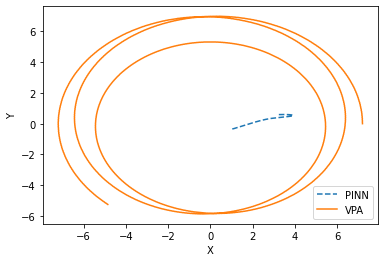

Epoch [1/24000], Loss: 3.033e+05,   LOSS_function: 1.28e+05,   LOSS_E:0.0002915,    LOSS_initial: 94.42,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 0.8174021244049072
loss_compared with real:54.264,   miu_train:0.013,  E:0.1185    lossmean:-0.2768
Epoch [100/24000], Loss: 3028,   LOSS_function: 29.95,   LOSS_E:0.3662,    LOSS_initial: 5.926,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 3.971514940261841
loss_compared with real:7.9171,   miu_train:0.0001257,  E:5.626    lossmean:0.1588
Epoch [200/24000], Loss: 46.83,   LOSS_function: 4.157,   LOSS_E:2.561,    LOSS_initial: 0.0001941,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 7.317097425460815
loss_compared with real:1.7408,   miu_train:2.997e-05,  E:14.75    lossmean:0.1702
Epoch [300/24000], Loss: 44.47,   LOSS_function: 3.585,   LOSS_E:2.482,    LOSS_initial: 0.0001374,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 10.7124452590

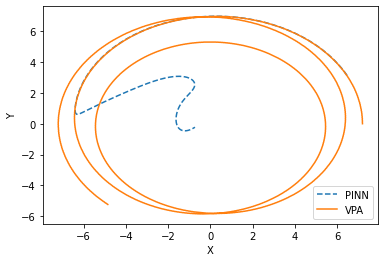

Epoch [600/24000], Loss: 43.54,   LOSS_function: 5.038,   LOSS_E:2.146,    LOSS_initial: 0.002538,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 21.64044976234436
loss_compared with real:1.2833,   miu_train:3.905e-05,  E:15.63    lossmean:0.1692
Epoch [700/24000], Loss: 34.8,   LOSS_function: 2.868,   LOSS_E:1.935,    LOSS_initial: 8.11e-05,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 24.98835515975952
loss_compared with real:1.0436,   miu_train:3.393e-05,  E:16.16    lossmean:0.148
Epoch [800/24000], Loss: 96.64,   LOSS_function: 34.11,   LOSS_E:1.852,    LOSS_initial: 0.001307,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 28.376373529434204
loss_compared with real:1.0019,   miu_train:6.197e-05,  E:16.24    lossmean:0.1486
Epoch [900/24000], Loss: 30,   LOSS_function: 2.695,   LOSS_E:1.637,    LOSS_initial: 0.0001097,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 31.88698387145996
lo

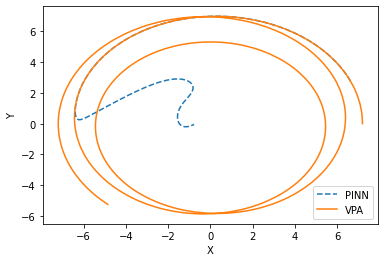

Epoch [1100/24000], Loss: 81.25,   LOSS_function: 2.585,   LOSS_E:1.052,    LOSS_initial: 8.964e-05,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      learn rate:0.00188,    time: 39.624608516693115
loss_compared with real:0.37208,   miu_train:4.692e-05,  E:18.69    lossmean:0.1007
Epoch [1200/24000], Loss: 183.6,   LOSS_function: 88.19,   LOSS_E:0.4763,    LOSS_initial: 0.02899,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      learn rate:0.00188,    time: 43.1605110168457
loss_compared with real:0.16769,   miu_train:0.001869,  E:20.42    lossmean:0.08265
Epoch [1300/24000], Loss: 208.6,   LOSS_function: 33.49,   LOSS_E:0.5808,    LOSS_initial: 0.08706,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      learn rate:0.00188,    time: 46.67957329750061
loss_compared with real:0.25633,   miu_train:0.0004834,  E:19.51    lossmean:0.1663
Epoch [1400/24000], Loss: 28.9,   LOSS_function: 1.333,   LOSS_E:0.3666,    LOSS_initial: 8.152e-05,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      l

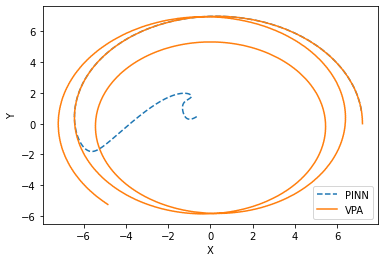

Epoch [1600/24000], Loss: 10.23,   LOSS_function: 2.101,   LOSS_E:0.1013,    LOSS_initial: 0.0001295,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      learn rate:0.00188,    time: 58.04521679878235
loss_compared with real:0.0049058,   miu_train:5.311e-05,  E:23.81    lossmean:0.01114
Epoch [1700/24000], Loss: 8.272,   LOSS_function: 1.077,   LOSS_E:0.09303,    LOSS_initial: 5.195e-05,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      learn rate:0.00188,    time: 61.54082918167114
loss_compared with real:0.0061959,   miu_train:5.68e-05,  E:23.57    lossmean:0.01491
Epoch [1800/24000], Loss: 110.5,   LOSS_function: 70.68,   LOSS_E:0.07247,    LOSS_initial: 0.01367,
lamda1:1.21,    lamda2:74.11,    lamda3:1437,      learn rate:0.00188,    time: 65.00688362121582
loss_compared with real:0.029494,   miu_train:4.54e-05,  E:23.04    lossmean:0.0234
Epoch [1900/24000], Loss: 7.831,   LOSS_function: 2.219,   LOSS_E:0.06585,    LOSS_initial: 0.0001856,
lamda1:1.21,    lamda2:74.11,    lamda3:

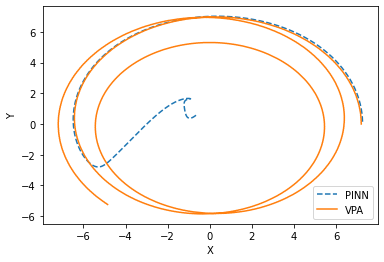

Epoch [2100/24000], Loss: 168.3,   LOSS_function: 75.01,   LOSS_E:0.001841,    LOSS_initial: 0.03875,
lamda1:1.042,    lamda2:1.389e+04,    lamda3:1665,      learn rate:0.001767,    time: 76.11138820648193
loss_compared with real:0.024144,   miu_train:0.0006808,  E:26.49    lossmean:-0.008384
Epoch [2200/24000], Loss: 8.437,   LOSS_function: 4,   LOSS_E:0.0002398,    LOSS_initial: 0.0005627,
lamda1:1.042,    lamda2:1.389e+04,    lamda3:1665,      learn rate:0.001767,    time: 79.51547908782959
loss_compared with real:0.00065253,   miu_train:3.211e-05,  E:24.86    lossmean:0.009556
Epoch [2300/24000], Loss: 21.08,   LOSS_function: 11.29,   LOSS_E:0.0002502,    LOSS_initial: 0.003507,
lamda1:1.042,    lamda2:1.389e+04,    lamda3:1665,      learn rate:0.001767,    time: 83.00336456298828
loss_compared with real:0.0036993,   miu_train:0.0001223,  E:25.11    lossmean:0.001317
Epoch [2400/24000], Loss: 77.51,   LOSS_function: 43.36,   LOSS_E:0.001223,    LOSS_initial: 0.009202,
lamda1:1.042,

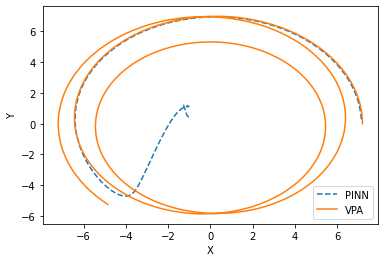

Epoch [2600/24000], Loss: 49.12,   LOSS_function: 9.458,   LOSS_E:0.0006418,    LOSS_initial: 0.01822,
lamda1:1.042,    lamda2:1.389e+04,    lamda3:1665,      learn rate:0.001767,    time: 94.54293918609619
loss_compared with real:0.0076765,   miu_train:0.0001312,  E:23.99    lossmean:-0.002319
Epoch [2700/24000], Loss: 45.57,   LOSS_function: 12.01,   LOSS_E:0.0003419,    LOSS_initial: 0.01699,
lamda1:1.042,    lamda2:1.389e+04,    lamda3:1665,      learn rate:0.001767,    time: 98.11847352981567
loss_compared with real:0.018391,   miu_train:0.0001164,  E:23.49    lossmean:0.01304
Epoch [2800/24000], Loss: 20.19,   LOSS_function: 2.272,   LOSS_E:0.0003291,    LOSS_initial: 0.007958,
lamda1:1.042,    lamda2:1.389e+04,    lamda3:1665,      learn rate:0.001767,    time: 101.714031457901
loss_compared with real:0.0099183,   miu_train:9.523e-05,  E:23.92    lossmean:0.007783
Epoch [2900/24000], Loss: 188.7,   LOSS_function: 98.85,   LOSS_E:0.002225,    LOSS_initial: 0.0329,
lamda1:1.042,  

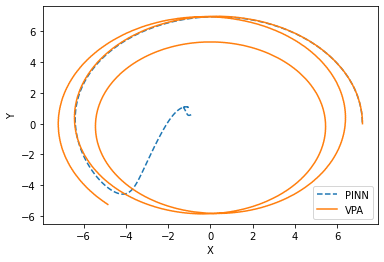

Epoch [3100/24000], Loss: 196,   LOSS_function: 21.4,   LOSS_E:0.001089,    LOSS_initial: 0.0577,
lamda1:1.009,    lamda2:2.584e+04,    lamda3:2534,      learn rate:0.001661,    time: 114.04520058631897
loss_compared with real:0.070168,   miu_train:0.0002172,  E:22.38    lossmean:0.024
Epoch [3200/24000], Loss: 60.74,   LOSS_function: 10.36,   LOSS_E:0.0002761,    LOSS_initial: 0.01703,
lamda1:1.009,    lamda2:2.584e+04,    lamda3:2534,      learn rate:0.001661,    time: 118.2514476776123
loss_compared with real:0.020345,   miu_train:0.0001536,  E:23.53    lossmean:0.01141
Epoch [3300/24000], Loss: 17.71,   LOSS_function: 6.134,   LOSS_E:0.0001873,    LOSS_initial: 0.002637,
lamda1:1.009,    lamda2:2.584e+04,    lamda3:2534,      learn rate:0.001661,    time: 122.06956648826599
loss_compared with real:0.0020321,   miu_train:0.0001159,  E:24.44    lossmean:0.003886
Epoch [3400/24000], Loss: 55.68,   LOSS_function: 41.66,   LOSS_E:0.0002776,    LOSS_initial: 0.002561,
lamda1:1.009,    la

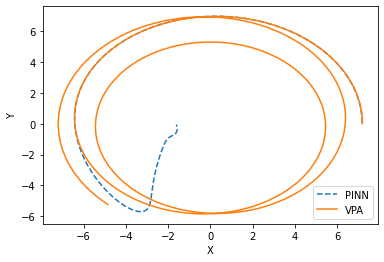

Epoch [3600/24000], Loss: 22.83,   LOSS_function: 11.7,   LOSS_E:5.488e-05,    LOSS_initial: 0.003793,
lamda1:1.009,    lamda2:2.584e+04,    lamda3:2534,      learn rate:0.001661,    time: 134.17238187789917
loss_compared with real:0.0022145,   miu_train:9.886e-05,  E:24.35    lossmean:0.0001698
Epoch [3700/24000], Loss: 11.16,   LOSS_function: 1.676,   LOSS_E:5.727e-05,    LOSS_initial: 0.003154,
lamda1:1.009,    lamda2:2.584e+04,    lamda3:2534,      learn rate:0.001661,    time: 137.85226941108704
loss_compared with real:0.0042025,   miu_train:7.411e-05,  E:24.23    lossmean:0.008472
Epoch [3800/24000], Loss: 58.84,   LOSS_function: 26.76,   LOSS_E:0.0005617,    LOSS_initial: 0.006838,
lamda1:1.009,    lamda2:2.584e+04,    lamda3:2534,      learn rate:0.001661,    time: 141.49268555641174
loss_compared with real:0.0083163,   miu_train:0.0001479,  E:24.07    lossmean:0.01998
Epoch [3900/24000], Loss: 53.74,   LOSS_function: 31.58,   LOSS_E:0.0001636,    LOSS_initial: 0.006969,
lamda1

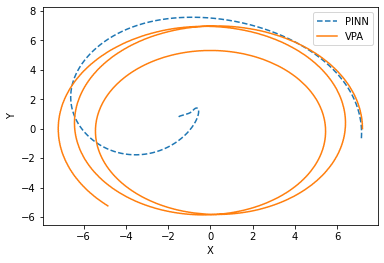

Epoch [4100/24000], Loss: 1.837e+04,   LOSS_function: 4804,   LOSS_E:0.1273,    LOSS_initial: 1.655,
lamda1:1.002,    lamda2:8.058e+04,    lamda3:1997,      learn rate:0.001561,    time: 153.26424551010132
loss_compared with real:16.99,   miu_train:0.09155,  E:20.08    lossmean:-1.782
Epoch [4200/24000], Loss: 542.7,   LOSS_function: 284.6,   LOSS_E:0.001973,    LOSS_initial: 0.04935,
lamda1:1.002,    lamda2:8.058e+04,    lamda3:1997,      learn rate:0.001561,    time: 156.9114854335785
loss_compared with real:1.3949,   miu_train:0.006996,  E:21.88    lossmean:-0.4958
Epoch [4300/24000], Loss: 1098,   LOSS_function: 161.1,   LOSS_E:0.01138,    LOSS_initial: 0.00979,
lamda1:1.002,    lamda2:8.058e+04,    lamda3:1997,      learn rate:0.001561,    time: 160.54702258110046
loss_compared with real:0.039016,   miu_train:0.003092,  E:26.16    lossmean:-0.02371
Epoch [4400/24000], Loss: 264.7,   LOSS_function: 135.9,   LOSS_E:0.0007698,    LOSS_initial: 0.0333,
lamda1:1.002,    lamda2:8.058e+0

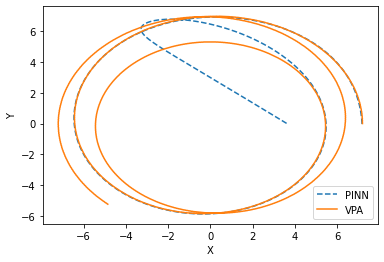

Epoch [4600/24000], Loss: 20.1,   LOSS_function: 13.23,   LOSS_E:7.151e-05,    LOSS_initial: 0.0005393,
lamda1:1.002,    lamda2:8.058e+04,    lamda3:1997,      learn rate:0.001561,    time: 172.45787715911865
loss_compared with real:0.0017203,   miu_train:0.0004605,  E:24.88    lossmean:0.01574
Epoch [4700/24000], Loss: 30.87,   LOSS_function: 20.59,   LOSS_E:0.0001128,    LOSS_initial: 0.0005713,
lamda1:1.002,    lamda2:8.058e+04,    lamda3:1997,      learn rate:0.001561,    time: 176.33473992347717
loss_compared with real:0.0011148,   miu_train:0.0004562,  E:24.64    lossmean:-0.01074
Epoch [4800/24000], Loss: 25.15,   LOSS_function: 12.98,   LOSS_E:0.0001337,    LOSS_initial: 0.0006858,
lamda1:1.002,    lamda2:8.058e+04,    lamda3:1997,      learn rate:0.001561,    time: 180.42899990081787
loss_compared with real:0.00055833,   miu_train:0.0002902,  E:24.71    lossmean:0.01481
Epoch [4900/24000], Loss: 38.57,   LOSS_function: 8.652,   LOSS_E:0.0003355,    LOSS_initial: 0.001434,
lamd

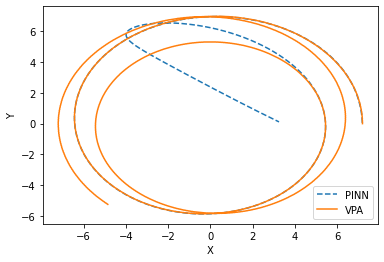

Epoch [5100/24000], Loss: 15.85,   LOSS_function: 13.74,   LOSS_E:3.867e-05,    LOSS_initial: 9.855e-05,
lamda1:1.001,    lamda2:4.454e+04,    lamda3:3806,      learn rate:0.001468,    time: 192.97584915161133
loss_compared with real:0.00022083,   miu_train:0.0001977,  E:24.72    lossmean:0.01156
Epoch [5200/24000], Loss: 8.022,   LOSS_function: 3.681,   LOSS_E:8.07e-05,    LOSS_initial: 0.0001955,
lamda1:1.001,    lamda2:4.454e+04,    lamda3:3806,      learn rate:0.001468,    time: 196.86939811706543
loss_compared with real:0.00098822,   miu_train:0.0001825,  E:24.61    lossmean:0.0007726
Epoch [5300/24000], Loss: 6.82,   LOSS_function: 4.331,   LOSS_E:2.135e-05,    LOSS_initial: 0.0004034,
lamda1:1.001,    lamda2:4.454e+04,    lamda3:3806,      learn rate:0.001468,    time: 200.56574726104736
loss_compared with real:0.00049173,   miu_train:0.0001571,  E:24.64    lossmean:0.0004961
Epoch [5400/24000], Loss: 259.6,   LOSS_function: 215.1,   LOSS_E:0.0007225,    LOSS_initial: 0.003193,


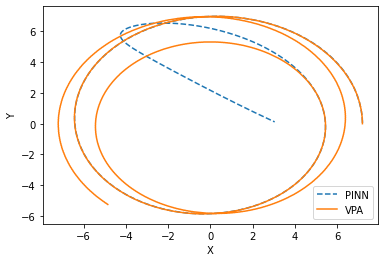

Epoch [5600/24000], Loss: 35.29,   LOSS_function: 26.77,   LOSS_E:0.0001684,    LOSS_initial: 0.0002617,
lamda1:1.001,    lamda2:4.454e+04,    lamda3:3806,      learn rate:0.001468,    time: 212.57568740844727
loss_compared with real:0.0025843,   miu_train:0.0001992,  E:24.63    lossmean:-0.01155
Epoch [5700/24000], Loss: 18.21,   LOSS_function: 11.16,   LOSS_E:0.0001187,    LOSS_initial: 0.0004625,
lamda1:1.001,    lamda2:4.454e+04,    lamda3:3806,      learn rate:0.001468,    time: 216.20795798301697
loss_compared with real:0.00046368,   miu_train:0.0001763,  E:24.77    lossmean:-0.001115
Epoch [5800/24000], Loss: 400,   LOSS_function: 334.2,   LOSS_E:0.0009242,    LOSS_initial: 0.006406,
lamda1:1.001,    lamda2:4.454e+04,    lamda3:3806,      learn rate:0.001468,    time: 219.92993712425232
loss_compared with real:0.0084291,   miu_train:0.000535,  E:24.56    lossmean:-0.03356
Epoch [5900/24000], Loss: 26.81,   LOSS_function: 21.76,   LOSS_E:9.227e-05,    LOSS_initial: 0.0002423,
lam

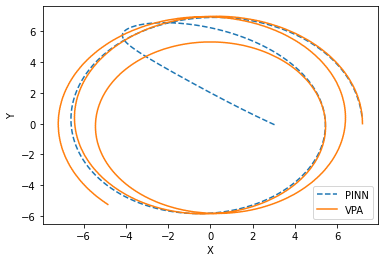

Epoch [6100/24000], Loss: 1670,   LOSS_function: 425,   LOSS_E:0.009249,    LOSS_initial: 0.006872,
lamda1:1,    lamda2:1.216e+05,    lamda3:1.745e+04,      learn rate:0.00138,    time: 231.7420153617859
loss_compared with real:1.5099,   miu_train:0.008759,  E:21.48    lossmean:-0.5779
Epoch [6200/24000], Loss: 785.8,   LOSS_function: 387.6,   LOSS_E:0.002851,    LOSS_initial: 0.00294,
lamda1:1,    lamda2:1.216e+05,    lamda3:1.745e+04,      learn rate:0.00138,    time: 235.4079601764679
loss_compared with real:0.8154,   miu_train:0.006189,  E:22.42    lossmean:-0.4336
Epoch [6300/24000], Loss: 265.5,   LOSS_function: 164.8,   LOSS_E:0.0005906,    LOSS_initial: 0.001654,
lamda1:1,    lamda2:1.216e+05,    lamda3:1.745e+04,      learn rate:0.00138,    time: 239.14923810958862
loss_compared with real:0.41341,   miu_train:0.004009,  E:23.21    lossmean:-0.3019
Epoch [6400/24000], Loss: 425.5,   LOSS_function: 282.1,   LOSS_E:0.0008942,    LOSS_initial: 0.001983,
lamda1:1,    lamda2:1.216e+

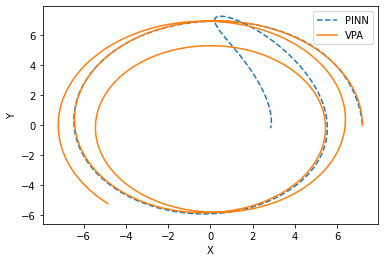

Epoch [6600/24000], Loss: 219.6,   LOSS_function: 102.1,   LOSS_E:0.0009441,    LOSS_initial: 0.0001526,
lamda1:1,    lamda2:1.216e+05,    lamda3:1.745e+04,      learn rate:0.00138,    time: 251.36285519599915
loss_compared with real:0.0035368,   miu_train:0.001289,  E:25.01    lossmean:0.01213
Epoch [6700/24000], Loss: 121,   LOSS_function: 45.77,   LOSS_E:0.0005989,    LOSS_initial: 0.0001379,
lamda1:1,    lamda2:1.216e+05,    lamda3:1.745e+04,      learn rate:0.00138,    time: 255.221333026886
loss_compared with real:0.0067639,   miu_train:0.001037,  E:25.09    lossmean:0.03549
Epoch [6800/24000], Loss: 52.12,   LOSS_function: 34.67,   LOSS_E:0.0001386,    LOSS_initial: 3.332e-05,
lamda1:1,    lamda2:1.216e+05,    lamda3:1.745e+04,      learn rate:0.00138,    time: 258.92448258399963
loss_compared with real:0.0014036,   miu_train:0.0007849,  E:24.78    lossmean:-0.003399
Epoch [6900/24000], Loss: 42.16,   LOSS_function: 28.34,   LOSS_E:0.0001101,    LOSS_initial: 2.421e-05,
lamda1:1

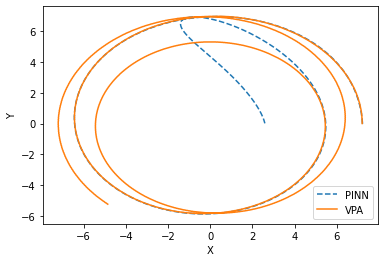

Epoch [7100/24000], Loss: 33.09,   LOSS_function: 18.62,   LOSS_E:0.0002039,    LOSS_initial: 4.293e-05,
lamda1:1,    lamda2:6.694e+04,    lamda3:1.903e+04,      learn rate:0.001297,    time: 271.17948484420776
loss_compared with real:0.0045216,   miu_train:0.0004577,  E:25    lossmean:0.033
Epoch [7200/24000], Loss: 17.53,   LOSS_function: 10.83,   LOSS_E:8.918e-05,    LOSS_initial: 3.831e-05,
lamda1:1,    lamda2:6.694e+04,    lamda3:1.903e+04,      learn rate:0.001297,    time: 274.8604350090027
loss_compared with real:0.0085723,   miu_train:0.0003754,  E:25.08    lossmean:0.04435
Epoch [7300/24000], Loss: 26.16,   LOSS_function: 16.57,   LOSS_E:0.0001304,    LOSS_initial: 4.508e-05,
lamda1:1,    lamda2:6.694e+04,    lamda3:1.903e+04,      learn rate:0.001297,    time: 278.62045645713806
loss_compared with real:0.006941,   miu_train:0.0003309,  E:25.06    lossmean:0.03895
Epoch [7400/24000], Loss: 13.48,   LOSS_function: 6.101,   LOSS_E:0.0001073,    LOSS_initial: 1.011e-05,
lamda1:1

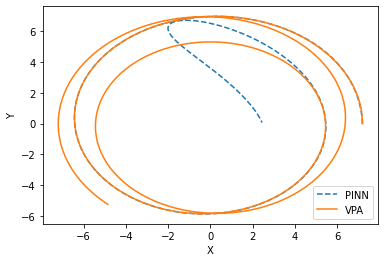

Epoch [7600/24000], Loss: 20.56,   LOSS_function: 6.234,   LOSS_E:0.0002129,    LOSS_initial: 3.727e-06,
lamda1:1,    lamda2:6.694e+04,    lamda3:1.903e+04,      learn rate:0.001297,    time: 290.74864506721497
loss_compared with real:0.0042856,   miu_train:0.0002626,  E:25    lossmean:0.03667
Epoch [7700/24000], Loss: 18.73,   LOSS_function: 5.685,   LOSS_E:0.000192,    LOSS_initial: 9.914e-06,
lamda1:1,    lamda2:6.694e+04,    lamda3:1.903e+04,      learn rate:0.001297,    time: 294.337975025177
loss_compared with real:0.0055167,   miu_train:0.0002322,  E:25.03    lossmean:0.03605
Epoch [7800/24000], Loss: 9.987,   LOSS_function: 6.597,   LOSS_E:4.278e-05,    LOSS_initial: 2.764e-05,
lamda1:1,    lamda2:6.694e+04,    lamda3:1.903e+04,      learn rate:0.001297,    time: 297.91358160972595
loss_compared with real:0.0055275,   miu_train:0.0002346,  E:25.03    lossmean:0.03448
Epoch [7900/24000], Loss: 15.04,   LOSS_function: 4.474,   LOSS_E:0.0001545,    LOSS_initial: 1.161e-05,
lamda1:

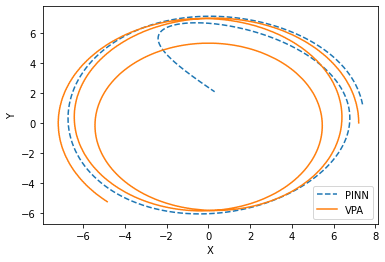

Epoch [8100/24000], Loss: 4323,   LOSS_function: 3643,   LOSS_E:0.01207,    LOSS_initial: 0.007384,
lamda1:1,    lamda2:4.463e+04,    lamda3:1.903e+04,      learn rate:0.001219,    time: 310.27540946006775
loss_compared with real:56.642,   miu_train:0.0818,  E:23.75    lossmean:0.81
Epoch [8200/24000], Loss: 1918,   LOSS_function: 1695,   LOSS_E:0.004078,    LOSS_initial: 0.002135,
lamda1:1,    lamda2:4.463e+04,    lamda3:1.903e+04,      learn rate:0.001219,    time: 314.1390082836151
loss_compared with real:29.018,   miu_train:0.0339,  E:24.48    lossmean:1.682
Epoch [8300/24000], Loss: 987.7,   LOSS_function: 818.7,   LOSS_E:0.00352,    LOSS_initial: 0.0006253,
lamda1:1,    lamda2:4.463e+04,    lamda3:1.903e+04,      learn rate:0.001219,    time: 317.9904797077179
loss_compared with real:11.816,   miu_train:0.01261,  E:24.71    lossmean:1.558
Epoch [8400/24000], Loss: 557.6,   LOSS_function: 444.5,   LOSS_E:0.002247,    LOSS_initial: 0.000669,
lamda1:1,    lamda2:4.463e+04,    lamda3

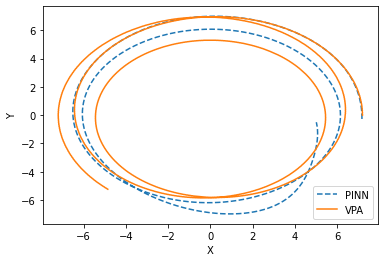

Epoch [8600/24000], Loss: 505.4,   LOSS_function: 411.2,   LOSS_E:0.002043,    LOSS_initial: 0.000152,
lamda1:1,    lamda2:4.463e+04,    lamda3:1.903e+04,      learn rate:0.001219,    time: 330.6312427520752
loss_compared with real:0.20328,   miu_train:0.002016,  E:25.82    lossmean:0.2394
Epoch [8700/24000], Loss: 159.6,   LOSS_function: 82.63,   LOSS_E:0.001515,    LOSS_initial: 0.0004909,
lamda1:1,    lamda2:4.463e+04,    lamda3:1.903e+04,      learn rate:0.001219,    time: 334.66678977012634
loss_compared with real:0.097325,   miu_train:0.001009,  E:26.07    lossmean:0.1555
Epoch [8800/24000], Loss: 99.39,   LOSS_function: 41.9,   LOSS_E:0.001268,    LOSS_initial: 4.589e-05,
lamda1:1,    lamda2:4.463e+04,    lamda3:1.903e+04,      learn rate:0.001219,    time: 338.7081871032715
loss_compared with real:0.08259,   miu_train:0.0007892,  E:25.98    lossmean:0.06963
Epoch [8900/24000], Loss: 64.43,   LOSS_function: 28.97,   LOSS_E:0.0007373,    LOSS_initial: 0.0001337,
lamda1:1,    lamd

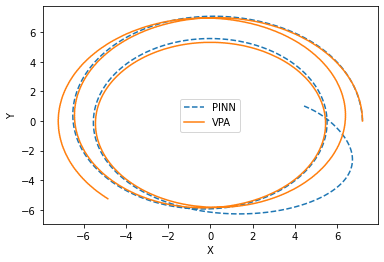

Epoch [9100/24000], Loss: 4105,   LOSS_function: 3198,   LOSS_E:0.006654,    LOSS_initial: 0.0005124,
lamda1:1,    lamda2:1.31e+05,    lamda3:6.942e+04,      learn rate:0.001146,    time: 351.13344836235046
loss_compared with real:37.261,   miu_train:0.06097,  E:24.4    lossmean:2.688
Epoch [9200/24000], Loss: 1393,   LOSS_function: 1222,   LOSS_E:0.001226,    LOSS_initial: 0.0001514,
lamda1:1,    lamda2:1.31e+05,    lamda3:6.942e+04,      learn rate:0.001146,    time: 355.0422832965851
loss_compared with real:16.532,   miu_train:0.02029,  E:24.41    lossmean:1.746
Epoch [9300/24000], Loss: 829.7,   LOSS_function: 699.6,   LOSS_E:0.0009503,    LOSS_initial: 8.182e-05,
lamda1:1,    lamda2:1.31e+05,    lamda3:6.942e+04,      learn rate:0.001146,    time: 358.9891924858093
loss_compared with real:7.2047,   miu_train:0.009917,  E:24.64    lossmean:1.364
Epoch [9400/24000], Loss: 535.8,   LOSS_function: 436.4,   LOSS_E:0.000693,    LOSS_initial: 0.0001241,
lamda1:1,    lamda2:1.31e+05,    l

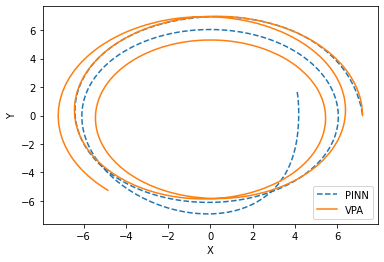

Epoch [9600/24000], Loss: 207.1,   LOSS_function: 162.5,   LOSS_E:0.0003143,    LOSS_initial: 4.975e-05,
lamda1:1,    lamda2:1.31e+05,    lamda3:6.942e+04,      learn rate:0.001146,    time: 371.23092436790466
loss_compared with real:1.6108,   miu_train:0.003079,  E:24.39    lossmean:0.6697
Epoch [9700/24000], Loss: 170.3,   LOSS_function: 136.8,   LOSS_E:0.000248,    LOSS_initial: 1.412e-05,
lamda1:1,    lamda2:1.31e+05,    lamda3:6.942e+04,      learn rate:0.001146,    time: 375.0107567310333
loss_compared with real:1.0627,   miu_train:0.002549,  E:24.54    lossmean:0.5171
Epoch [9800/24000], Loss: 246.9,   LOSS_function: 183.7,   LOSS_E:0.0004745,    LOSS_initial: 1.508e-05,
lamda1:1,    lamda2:1.31e+05,    lamda3:6.942e+04,      learn rate:0.001146,    time: 378.9313180446625
loss_compared with real:0.73697,   miu_train:0.002053,  E:24.5    lossmean:0.4237
Epoch [9900/24000], Loss: 110.5,   LOSS_function: 66.64,   LOSS_E:0.0003273,    LOSS_initial: 1.48e-05,
lamda1:1,    lamda2:1.3

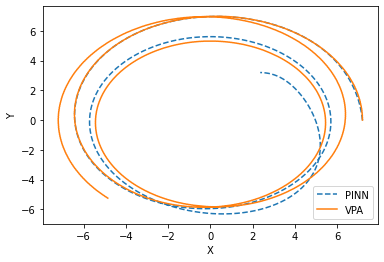

Epoch [10100/24000], Loss: 62.91,   LOSS_function: 38.64,   LOSS_E:0.0003776,    LOSS_initial: 1.719e-05,
lamda1:1,    lamda2:6.109e+04,    lamda3:6.942e+04,      learn rate:0.001077,    time: 391.5043160915375
loss_compared with real:0.06184,   miu_train:0.001225,  E:25.23    lossmean:0.1631
Epoch [10200/24000], Loss: 54.49,   LOSS_function: 24.22,   LOSS_E:0.0004771,    LOSS_initial: 1.619e-05,
lamda1:1,    lamda2:6.109e+04,    lamda3:6.942e+04,      learn rate:0.001077,    time: 395.4888868331909
loss_compared with real:0.032601,   miu_train:0.001001,  E:25.29    lossmean:0.1103
Epoch [10300/24000], Loss: 69.25,   LOSS_function: 34.85,   LOSS_E:0.0005477,    LOSS_initial: 1.35e-05,
lamda1:1,    lamda2:6.109e+04,    lamda3:6.942e+04,      learn rate:0.001077,    time: 399.7675006389618
loss_compared with real:0.026812,   miu_train:0.0008413,  E:25.36    lossmean:0.05652
Epoch [10400/24000], Loss: 61.32,   LOSS_function: 30.32,   LOSS_E:0.000487,    LOSS_initial: 1.801e-05,
lamda1:1, 

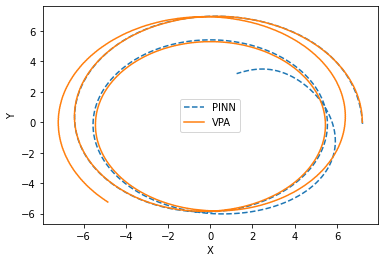

Epoch [10600/24000], Loss: 50.37,   LOSS_function: 21.57,   LOSS_E:0.0004367,    LOSS_initial: 3.051e-05,
lamda1:1,    lamda2:6.109e+04,    lamda3:6.942e+04,      learn rate:0.001077,    time: 413.7056405544281
loss_compared with real:0.11411,   miu_train:0.000619,  E:25.62    lossmean:-0.04049
Epoch [10700/24000], Loss: 54.9,   LOSS_function: 15.19,   LOSS_E:0.0006299,    LOSS_initial: 1.771e-05,
lamda1:1,    lamda2:6.109e+04,    lamda3:6.942e+04,      learn rate:0.001077,    time: 417.9899253845215
loss_compared with real:0.16422,   miu_train:0.0005719,  E:25.7    lossmean:-0.04749
Epoch [10800/24000], Loss: 44.25,   LOSS_function: 15.49,   LOSS_E:0.0004219,    LOSS_initial: 4.295e-05,
lamda1:1,    lamda2:6.109e+04,    lamda3:6.942e+04,      learn rate:0.001077,    time: 422.4080328941345
loss_compared with real:0.1186,   miu_train:0.0004123,  E:25.51    lossmean:-0.05457
Epoch [10900/24000], Loss: 46.99,   LOSS_function: 11.67,   LOSS_E:0.0005667,    LOSS_initial: 1.013e-05,
lamda1:

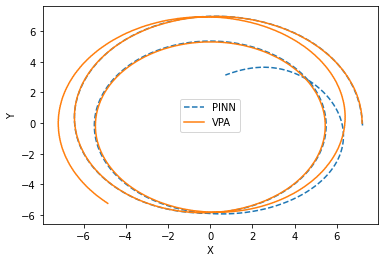

Epoch [11100/24000], Loss: 18.47,   LOSS_function: 7.403,   LOSS_E:0.0004468,    LOSS_initial: 1.395e-05,
lamda1:1,    lamda2:2.373e+04,    lamda3:3.304e+04,      learn rate:0.001013,    time: 437.0291197299957
loss_compared with real:0.14758,   miu_train:0.0002825,  E:25.46    lossmean:-0.06759
Epoch [11200/24000], Loss: 21.04,   LOSS_function: 3.174,   LOSS_E:0.0007354,    LOSS_initial: 1.27e-05,
lamda1:1,    lamda2:2.373e+04,    lamda3:3.304e+04,      learn rate:0.001013,    time: 441.988392829895
loss_compared with real:0.22066,   miu_train:0.0003371,  E:25.69    lossmean:-0.09078
Epoch [11300/24000], Loss: 20.71,   LOSS_function: 4.247,   LOSS_E:0.0006417,    LOSS_initial: 3.755e-05,
lamda1:1,    lamda2:2.373e+04,    lamda3:3.304e+04,      learn rate:0.001013,    time: 446.48842763900757
loss_compared with real:0.26141,   miu_train:0.0002694,  E:25.71    lossmean:-0.09264
Epoch [11400/24000], Loss: 15.3,   LOSS_function: 3.742,   LOSS_E:0.0004737,    LOSS_initial: 9.509e-06,
lamda

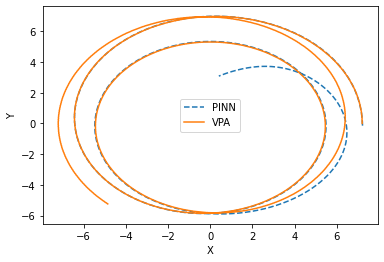

Epoch [11600/24000], Loss: 22.34,   LOSS_function: 13.51,   LOSS_E:0.0003577,    LOSS_initial: 1.052e-05,
lamda1:1,    lamda2:2.373e+04,    lamda3:3.304e+04,      learn rate:0.001013,    time: 461.2007088661194
loss_compared with real:0.19779,   miu_train:0.0002017,  E:25.55    lossmean:-0.09441
Epoch [11700/24000], Loss: 16.61,   LOSS_function: 3.622,   LOSS_E:0.0005402,    LOSS_initial: 5.024e-06,
lamda1:1,    lamda2:2.373e+04,    lamda3:3.304e+04,      learn rate:0.001013,    time: 465.8079266548157
loss_compared with real:0.20504,   miu_train:0.000187,  E:25.57    lossmean:-0.09075
Epoch [11800/24000], Loss: 10.89,   LOSS_function: 3.131,   LOSS_E:0.0003045,    LOSS_initial: 1.612e-05,
lamda1:1,    lamda2:2.373e+04,    lamda3:3.304e+04,      learn rate:0.001013,    time: 470.45884680747986
loss_compared with real:0.17329,   miu_train:0.0001766,  E:25.53    lossmean:-0.08744
Epoch [11900/24000], Loss: 12.41,   LOSS_function: 6.928,   LOSS_E:0.0002077,    LOSS_initial: 1.668e-05,
lam

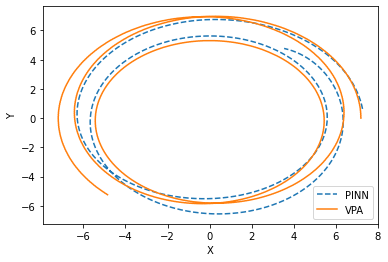

Epoch [12100/24000], Loss: 760.2,   LOSS_function: 649.7,   LOSS_E:0.002926,    LOSS_initial: 4.804e-05,
lamda1:1,    lamda2:3.695e+04,    lamda3:4.891e+04,      learn rate:0.0009518,    time: 485.49391078948975
loss_compared with real:19.616,   miu_train:0.008273,  E:25.8    lossmean:-1.965
Epoch [12200/24000], Loss: 369.7,   LOSS_function: 287.6,   LOSS_E:0.002177,    LOSS_initial: 3.478e-05,
lamda1:1,    lamda2:3.695e+04,    lamda3:4.891e+04,      learn rate:0.0009518,    time: 490.51675629615784
loss_compared with real:6.5414,   miu_train:0.003248,  E:25.83    lossmean:-1.248
Epoch [12300/24000], Loss: 193.2,   LOSS_function: 150,   LOSS_E:0.001114,    LOSS_initial: 4.364e-05,
lamda1:1,    lamda2:3.695e+04,    lamda3:4.891e+04,      learn rate:0.0009518,    time: 495.38003063201904
loss_compared with real:3.1518,   miu_train:0.001689,  E:25.55    lossmean:-0.8523
Epoch [12400/24000], Loss: 112.4,   LOSS_function: 81.08,   LOSS_E:0.0008315,    LOSS_initial: 1.123e-05,
lamda1:1,    l

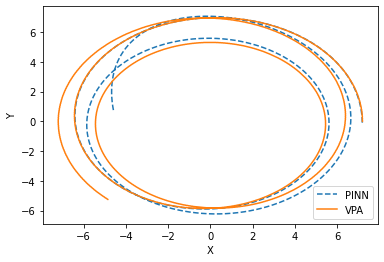

Epoch [12600/24000], Loss: 33.2,   LOSS_function: 21.16,   LOSS_E:0.0002742,    LOSS_initial: 3.904e-05,
lamda1:1,    lamda2:3.695e+04,    lamda3:4.891e+04,      learn rate:0.0009518,    time: 510.8135757446289
loss_compared with real:0.20268,   miu_train:0.0003201,  E:25.11    lossmean:-0.1966
Epoch [12700/24000], Loss: 25.74,   LOSS_function: 18.46,   LOSS_E:0.0001684,    LOSS_initial: 2.163e-05,
lamda1:1,    lamda2:3.695e+04,    lamda3:4.891e+04,      learn rate:0.0009518,    time: 515.7113637924194
loss_compared with real:0.056938,   miu_train:0.0002511,  E:25.17    lossmean:-0.08947
Epoch [12800/24000], Loss: 16.94,   LOSS_function: 9.011,   LOSS_E:0.0002012,    LOSS_initial: 1.005e-05,
lamda1:1,    lamda2:3.695e+04,    lamda3:4.891e+04,      learn rate:0.0009518,    time: 520.8468544483185
loss_compared with real:0.024674,   miu_train:0.0001758,  E:24.96    lossmean:-0.05468
Epoch [12900/24000], Loss: 17.71,   LOSS_function: 7.327,   LOSS_E:0.0001715,    LOSS_initial: 8.281e-05,


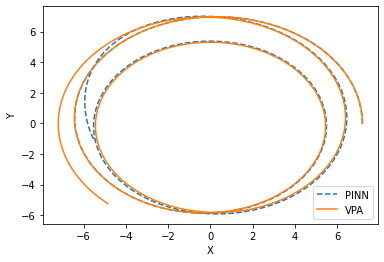

Epoch [13100/24000], Loss: 10.93,   LOSS_function: 4.825,   LOSS_E:0.0002506,    LOSS_initial: 5.148e-05,
lamda1:1,    lamda2:1.973e+04,    lamda3:2.256e+04,      learn rate:0.0008947,    time: 536.5090281963348
loss_compared with real:0.046867,   miu_train:0.000125,  E:25.15    lossmean:0.07163
Epoch [13200/24000], Loss: 7.808,   LOSS_function: 3.435,   LOSS_E:0.0002195,    LOSS_initial: 1.883e-06,
lamda1:1,    lamda2:1.973e+04,    lamda3:2.256e+04,      learn rate:0.0008947,    time: 541.6423215866089
loss_compared with real:0.05625,   miu_train:0.0001078,  E:25.09    lossmean:0.07691
Epoch [13300/24000], Loss: 6.93,   LOSS_function: 4.059,   LOSS_E:0.0001415,    LOSS_initial: 3.481e-06,
lamda1:1,    lamda2:1.973e+04,    lamda3:2.256e+04,      learn rate:0.0008947,    time: 546.7570652961731
loss_compared with real:0.078285,   miu_train:0.0001119,  E:25.18    lossmean:0.09562
Epoch [13400/24000], Loss: 6.11,   LOSS_function: 2.829,   LOSS_E:0.0001616,    LOSS_initial: 4.093e-06,
lamd

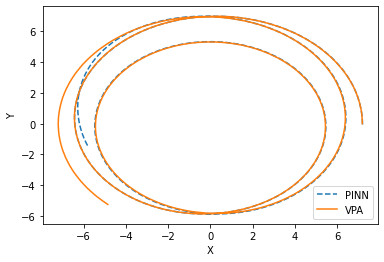

Epoch [13600/24000], Loss: 3.409,   LOSS_function: 1.794,   LOSS_E:8.041e-05,    LOSS_initial: 1.272e-06,
lamda1:1,    lamda2:1.973e+04,    lamda3:2.256e+04,      learn rate:0.0008947,    time: 562.6411461830139
loss_compared with real:0.058293,   miu_train:9.072e-05,  E:25.05    lossmean:0.08593
Epoch [13700/24000], Loss: 7.673,   LOSS_function: 3.725,   LOSS_E:0.0001959,    LOSS_initial: 3.674e-06,
lamda1:1,    lamda2:1.973e+04,    lamda3:2.256e+04,      learn rate:0.0008947,    time: 567.7327706813812
loss_compared with real:0.083818,   miu_train:0.0001059,  E:25.16    lossmean:0.1016
Epoch [13800/24000], Loss: 18.63,   LOSS_function: 16.05,   LOSS_E:0.0001261,    LOSS_initial: 4.192e-06,
lamda1:1,    lamda2:1.973e+04,    lamda3:2.256e+04,      learn rate:0.0008947,    time: 572.8286409378052
loss_compared with real:0.072248,   miu_train:0.0001215,  E:25.12    lossmean:0.1008
Epoch [13900/24000], Loss: 7.465,   LOSS_function: 3.664,   LOSS_E:0.0001916,    LOSS_initial: 8.435e-07,
la

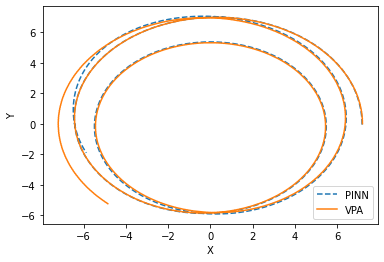

Epoch [14100/24000], Loss: 41.73,   LOSS_function: 29.91,   LOSS_E:0.0001798,    LOSS_initial: 5.834e-05,
lamda1:1,    lamda2:5.841e+04,    lamda3:2.256e+04,      learn rate:0.000841,    time: 589.1976146697998
loss_compared with real:0.26646,   miu_train:0.0005135,  E:25.48    lossmean:-0.1645
Epoch [14200/24000], Loss: 12.95,   LOSS_function: 6.655,   LOSS_E:9.573e-05,    LOSS_initial: 3.103e-05,
lamda1:1,    lamda2:5.841e+04,    lamda3:2.256e+04,      learn rate:0.000841,    time: 594.3879442214966
loss_compared with real:0.053198,   miu_train:0.0001957,  E:25.24    lossmean:0.03195
Epoch [14300/24000], Loss: 7.248,   LOSS_function: 3.683,   LOSS_E:5.604e-05,    LOSS_initial: 1.293e-05,
lamda1:1,    lamda2:5.841e+04,    lamda3:2.256e+04,      learn rate:0.000841,    time: 599.5369579792023
loss_compared with real:0.0391,   miu_train:0.0001402,  E:25.08    lossmean:0.06222
Epoch [14400/24000], Loss: 8.738,   LOSS_function: 3.204,   LOSS_E:6.312e-05,    LOSS_initial: 8.186e-05,
lamda1

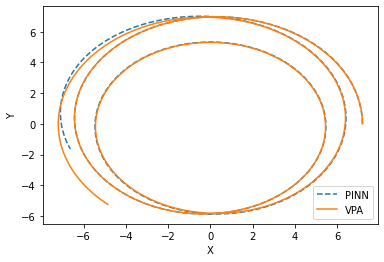

Epoch [14600/24000], Loss: 6.713,   LOSS_function: 3.79,   LOSS_E:3.985e-05,    LOSS_initial: 2.639e-05,
lamda1:1,    lamda2:5.841e+04,    lamda3:2.256e+04,      learn rate:0.000841,    time: 615.7108933925629
loss_compared with real:0.089724,   miu_train:0.0001204,  E:25.15    lossmean:0.1112
Epoch [14700/24000], Loss: 9.716,   LOSS_function: 6.089,   LOSS_E:4.936e-05,    LOSS_initial: 3.298e-05,
lamda1:1,    lamda2:5.841e+04,    lamda3:2.256e+04,      learn rate:0.000841,    time: 620.9433109760284
loss_compared with real:0.06879,   miu_train:0.0001243,  E:25.12    lossmean:0.1058
Epoch [14800/24000], Loss: 7.873,   LOSS_function: 2.163,   LOSS_E:8.637e-05,    LOSS_initial: 2.947e-05,
lamda1:1,    lamda2:5.841e+04,    lamda3:2.256e+04,      learn rate:0.000841,    time: 626.1884109973907
loss_compared with real:0.020776,   miu_train:9.288e-05,  E:24.85    lossmean:0.05059
Epoch [14900/24000], Loss: 25.62,   LOSS_function: 11.95,   LOSS_E:0.0001164,    LOSS_initial: 0.0003045,
lamda1:

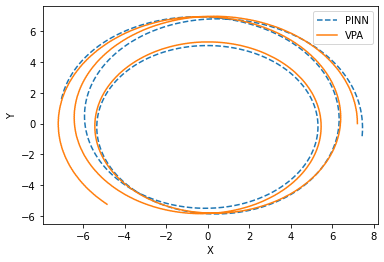

Epoch [15100/24000], Loss: 7118,   LOSS_function: 1303,   LOSS_E:0.0875,    LOSS_initial: 0.0001048,
lamda1:1,    lamda2:6.615e+04,    lamda3:2.652e+05,      learn rate:0.0007906,    time: 642.8144700527191
loss_compared with real:30.35,   miu_train:0.01616,  E:21.71    lossmean:-2.089
Epoch [15200/24000], Loss: 2815,   LOSS_function: 1208,   LOSS_E:0.02423,    LOSS_initial: 1.428e-05,
lamda1:1,    lamda2:6.615e+04,    lamda3:2.652e+05,      learn rate:0.0007906,    time: 648.1710464954376
loss_compared with real:18.047,   miu_train:0.01328,  E:25.39    lossmean:-1.633
Epoch [15300/24000], Loss: 996.2,   LOSS_function: 742.3,   LOSS_E:0.003801,    LOSS_initial: 9.239e-06,
lamda1:1,    lamda2:6.615e+04,    lamda3:2.652e+05,      learn rate:0.0007906,    time: 653.6255497932434
loss_compared with real:12.996,   miu_train:0.00932,  E:25.89    lossmean:-1.581
Epoch [15400/24000], Loss: 616.1,   LOSS_function: 430.5,   LOSS_E:0.002766,    LOSS_initial: 9.767e-06,
lamda1:1,    lamda2:6.615e+

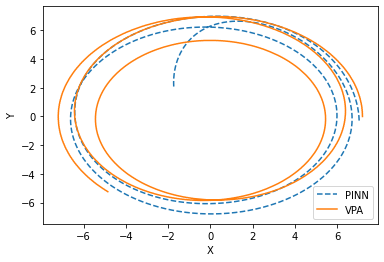

Epoch [15600/24000], Loss: 257.5,   LOSS_function: 200.9,   LOSS_E:0.0008496,    LOSS_initial: 1.676e-06,
lamda1:1,    lamda2:6.615e+04,    lamda3:2.652e+05,      learn rate:0.0007906,    time: 670.4154162406921
loss_compared with real:5.2997,   miu_train:0.00293,  E:25.33    lossmean:-1.169
Epoch [15700/24000], Loss: 253,   LOSS_function: 181.9,   LOSS_E:0.00107,    LOSS_initial: 1.472e-06,
lamda1:1,    lamda2:6.615e+04,    lamda3:2.652e+05,      learn rate:0.0007906,    time: 675.8483393192291
loss_compared with real:4.206,   miu_train:0.002236,  E:25.14    lossmean:-1.048
Epoch [15800/24000], Loss: 188,   LOSS_function: 154.2,   LOSS_E:0.0005057,    LOSS_initial: 1.36e-06,
lamda1:1,    lamda2:6.615e+04,    lamda3:2.652e+05,      learn rate:0.0007906,    time: 681.298787355423
loss_compared with real:3.1244,   miu_train:0.001904,  E:25.14    lossmean:-0.8911
Epoch [15900/24000], Loss: 282.7,   LOSS_function: 118.1,   LOSS_E:0.002479,    LOSS_initial: 2.565e-06,
lamda1:1,    lamda2:6.

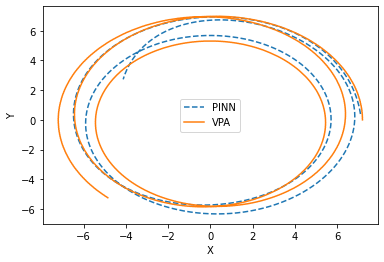

Epoch [16100/24000], Loss: 1929,   LOSS_function: 1416,   LOSS_E:0.007563,    LOSS_initial: 6.432e-06,
lamda1:1,    lamda2:6.77e+04,    lamda3:2.652e+05,      learn rate:0.0007431,    time: 699.0325095653534
loss_compared with real:49.365,   miu_train:0.0169,  E:24.4    lossmean:1.515
Epoch [16200/24000], Loss: 1063,   LOSS_function: 866.8,   LOSS_E:0.002872,    LOSS_initial: 6.173e-06,
lamda1:1,    lamda2:6.77e+04,    lamda3:2.652e+05,      learn rate:0.0007431,    time: 705.3014578819275
loss_compared with real:36.084,   miu_train:0.009988,  E:24.54    lossmean:1.397
Epoch [16300/24000], Loss: 704.7,   LOSS_function: 575.1,   LOSS_E:0.0019,    LOSS_initial: 3.658e-06,
lamda1:1,    lamda2:6.77e+04,    lamda3:2.652e+05,      learn rate:0.0007431,    time: 711.8206512928009
loss_compared with real:27.555,   miu_train:0.006746,  E:24.69    lossmean:1.328
Epoch [16400/24000], Loss: 597.1,   LOSS_function: 509.3,   LOSS_E:0.001292,    LOSS_initial: 1.338e-06,
lamda1:1,    lamda2:6.77e+04, 

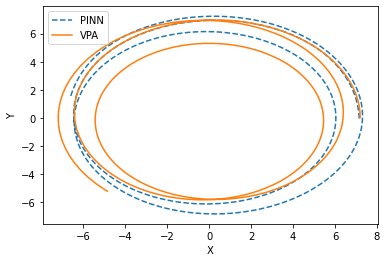

Epoch [16600/24000], Loss: 370.6,   LOSS_function: 322.1,   LOSS_E:0.0007066,    LOSS_initial: 2.513e-06,
lamda1:1,    lamda2:6.77e+04,    lamda3:2.652e+05,      learn rate:0.0007431,    time: 732.0924150943756
loss_compared with real:15.427,   miu_train:0.003415,  E:24.89    lossmean:1.137
Epoch [16700/24000], Loss: 318.3,   LOSS_function: 261.3,   LOSS_E:0.0008346,    LOSS_initial: 2.175e-06,
lamda1:1,    lamda2:6.77e+04,    lamda3:2.652e+05,      learn rate:0.0007431,    time: 738.4266772270203
loss_compared with real:13.212,   miu_train:0.002808,  E:24.86    lossmean:1.08
Epoch [16800/24000], Loss: 252,   LOSS_function: 209.1,   LOSS_E:0.0006278,    LOSS_initial: 1.224e-06,
lamda1:1,    lamda2:6.77e+04,    lamda3:2.652e+05,      learn rate:0.0007431,    time: 745.2659277915955
loss_compared with real:11.331,   miu_train:0.00245,  E:24.91    lossmean:1.01
Epoch [16900/24000], Loss: 273.2,   LOSS_function: 181,   LOSS_E:0.00134,    LOSS_initial: 5.792e-06,
lamda1:1,    lamda2:6.77e+0

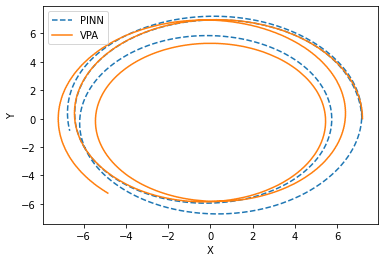

Epoch [17100/24000], Loss: 170.2,   LOSS_function: 137.9,   LOSS_E:0.0004701,    LOSS_initial: 1.258e-06,
lamda1:1,    lamda2:6.801e+04,    lamda3:2.652e+05,      learn rate:0.0006986,    time: 765.8106784820557
loss_compared with real:7.2097,   miu_train:0.001582,  E:24.92    lossmean:0.8382
Epoch [17200/24000], Loss: 161.2,   LOSS_function: 125.7,   LOSS_E:0.0005177,    LOSS_initial: 1.166e-06,
lamda1:1,    lamda2:6.801e+04,    lamda3:2.652e+05,      learn rate:0.0006986,    time: 772.3298811912537
loss_compared with real:5.9893,   miu_train:0.00142,  E:25.02    lossmean:0.7707
Epoch [17300/24000], Loss: 133.2,   LOSS_function: 111,   LOSS_E:0.0002912,    LOSS_initial: 9.046e-06,
lamda1:1,    lamda2:6.801e+04,    lamda3:2.652e+05,      learn rate:0.0006986,    time: 778.8996937274933
loss_compared with real:5.3104,   miu_train:0.001237,  E:24.95    lossmean:0.7459
Epoch [17400/24000], Loss: 162.4,   LOSS_function: 119,   LOSS_E:0.0004915,    LOSS_initial: 3.744e-05,
lamda1:1,    lamd

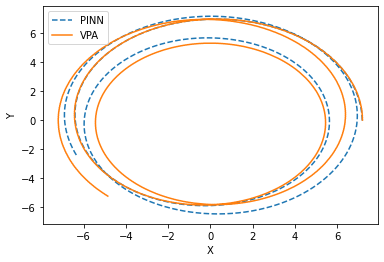

Epoch [17600/24000], Loss: 103.1,   LOSS_function: 81.05,   LOSS_E:0.0002214,    LOSS_initial: 2.642e-05,
lamda1:1,    lamda2:6.801e+04,    lamda3:2.652e+05,      learn rate:0.0006986,    time: 799.4490139484406
loss_compared with real:3.1809,   miu_train:0.0008461,  E:24.99    lossmean:0.5765
Epoch [17700/24000], Loss: 134,   LOSS_function: 63.02,   LOSS_E:0.0002152,    LOSS_initial: 0.0002125,
lamda1:1,    lamda2:6.801e+04,    lamda3:2.652e+05,      learn rate:0.0006986,    time: 806.1273336410522
loss_compared with real:2.797,   miu_train:0.0007621,  E:24.96    lossmean:0.5521
Epoch [17800/24000], Loss: 108,   LOSS_function: 59.05,   LOSS_E:0.0002525,    LOSS_initial: 0.0001199,
lamda1:1,    lamda2:6.801e+04,    lamda3:2.652e+05,      learn rate:0.0006986,    time: 812.8555030822754
loss_compared with real:2.2666,   miu_train:0.0006682,  E:24.97    lossmean:0.4866
Epoch [17900/24000], Loss: 363.5,   LOSS_function: 50.96,   LOSS_E:0.0004991,    LOSS_initial: 0.00105,
lamda1:1,    lam

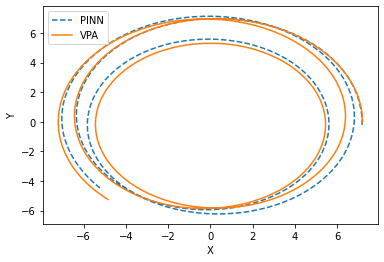

Epoch [18100/24000], Loss: 108,   LOSS_function: 81.81,   LOSS_E:0.0003772,    LOSS_initial: 1.6e-06,
lamda1:1,    lamda2:6.807e+04,    lamda3:3.138e+05,      learn rate:0.0006566,    time: 834.3189930915833
loss_compared with real:2.1701,   miu_train:0.0008274,  E:24.98    lossmean:0.5002
Epoch [18200/24000], Loss: 85,   LOSS_function: 55.16,   LOSS_E:0.0004349,    LOSS_initial: 7.247e-07,
lamda1:1,    lamda2:6.807e+04,    lamda3:3.138e+05,      learn rate:0.0006566,    time: 841.2184698581696
loss_compared with real:1.6585,   miu_train:0.0006705,  E:25.09    lossmean:0.4254
Epoch [18300/24000], Loss: 71,   LOSS_function: 49.66,   LOSS_E:0.000308,    LOSS_initial: 1.204e-06,
lamda1:1,    lamda2:6.807e+04,    lamda3:3.138e+05,      learn rate:0.0006566,    time: 848.2306416034698
loss_compared with real:1.3959,   miu_train:0.0005868,  E:25.05    lossmean:0.3846
Epoch [18400/24000], Loss: 89.61,   LOSS_function: 47.62,   LOSS_E:0.0006019,    LOSS_initial: 3.259e-06,
lamda1:1,    lamda2:

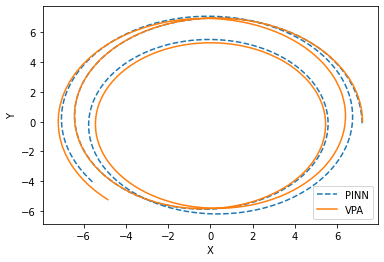

Epoch [18600/24000], Loss: 38.37,   LOSS_function: 27.43,   LOSS_E:0.0001577,    LOSS_initial: 6.632e-07,
lamda1:1,    lamda2:6.807e+04,    lamda3:3.138e+05,      learn rate:0.0006566,    time: 870.1015110015869
loss_compared with real:0.77469,   miu_train:0.0004296,  E:25.04    lossmean:0.282
Epoch [18700/24000], Loss: 38.25,   LOSS_function: 29.99,   LOSS_E:0.000119,    LOSS_initial: 4.97e-07,
lamda1:1,    lamda2:6.807e+04,    lamda3:3.138e+05,      learn rate:0.0006566,    time: 877.428272485733
loss_compared with real:0.60359,   miu_train:0.0003877,  E:25.04    lossmean:0.2511
Epoch [18800/24000], Loss: 33.88,   LOSS_function: 24.09,   LOSS_E:0.0001369,    LOSS_initial: 1.512e-06,
lamda1:1,    lamda2:6.807e+04,    lamda3:3.138e+05,      learn rate:0.0006566,    time: 884.5454626083374
loss_compared with real:0.48299,   miu_train:0.0003529,  E:25.01    lossmean:0.2281
Epoch [18900/24000], Loss: 31.62,   LOSS_function: 21.95,   LOSS_E:0.0001382,    LOSS_initial: 8.309e-07,
lamda1:1, 

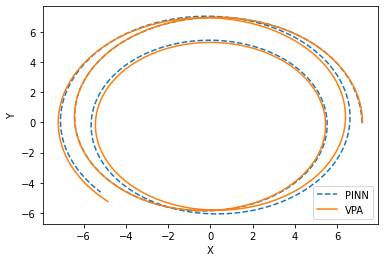

Epoch [19100/24000], Loss: 27.04,   LOSS_function: 18.44,   LOSS_E:0.000124,    LOSS_initial: 5.008e-07,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:0.0006172,    time: 907.0238654613495
loss_compared with real:0.19091,   miu_train:0.0002779,  E:25.08    lossmean:0.1334
Epoch [19200/24000], Loss: 24,   LOSS_function: 15.72,   LOSS_E:0.0001209,    LOSS_initial: 1.69e-07,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:0.0006172,    time: 914.4797165393829
loss_compared with real:0.1495,   miu_train:0.0002657,  E:25.09    lossmean:0.1141
Epoch [19300/24000], Loss: 43.66,   LOSS_function: 20.37,   LOSS_E:0.0003344,    LOSS_initial: 1.662e-06,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:0.0006172,    time: 921.8401472568512
loss_compared with real:0.10604,   miu_train:0.0002477,  E:25.1    lossmean:0.08844
Epoch [19400/24000], Loss: 27.92,   LOSS_function: 13.2,   LOSS_E:0.0002127,    LOSS_initial: 7.734e-07,
lamda1:1,    

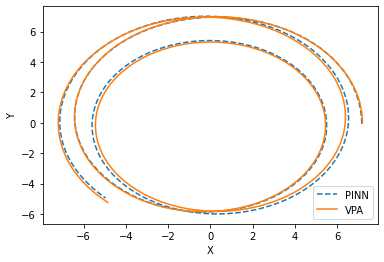

Epoch [19600/24000], Loss: 19.78,   LOSS_function: 12.04,   LOSS_E:0.0001093,    LOSS_initial: 9.464e-07,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:0.0006172,    time: 945.1245431900024
loss_compared with real:0.037985,   miu_train:0.0002214,  E:25.15    lossmean:0.03096
Epoch [19700/24000], Loss: 2739,   LOSS_function: 15.21,   LOSS_E:0.0009963,    LOSS_initial: 0.008463,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:0.0006172,    time: 952.4262456893921
loss_compared with real:0.075015,   miu_train:0.000249,  E:24.91    lossmean:0.07188
Epoch [19800/24000], Loss: 32.42,   LOSS_function: 8.946,   LOSS_E:0.00013,    LOSS_initial: 4.662e-05,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:0.0006172,    time: 959.839252948761
loss_compared with real:0.026566,   miu_train:0.0002089,  E:25.18    lossmean:0.005047
Epoch [19900/24000], Loss: 20.45,   LOSS_function: 10.96,   LOSS_E:9.84e-05,    LOSS_initial: 8.879e-06,
lamda1

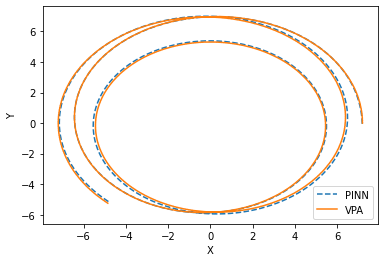

Epoch [20100/24000], Loss: 14.93,   LOSS_function: 9.447,   LOSS_E:8.043e-05,    LOSS_initial: 2.799e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.321e-05,    time: 983.2878088951111
loss_compared with real:0.019404,   miu_train:0.0001977,  E:25.09    lossmean:0.00647
Epoch [20200/24000], Loss: 16.58,   LOSS_function: 9.937,   LOSS_E:9.745e-05,    LOSS_initial: 3.106e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.321e-05,    time: 990.7293734550476
loss_compared with real:0.019337,   miu_train:0.0001954,  E:25.09    lossmean:0.006579
Epoch [20300/24000], Loss: 12.51,   LOSS_function: 8.686,   LOSS_E:5.604e-05,    LOSS_initial: 3.769e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.321e-05,    time: 998.5780618190765
loss_compared with real:0.019289,   miu_train:0.0001938,  E:25.09    lossmean:0.005254
Epoch [20400/24000], Loss: 14.11,   LOSS_function: 9.822,   LOSS_E:6.291e-05,    LOSS_initial: 1.484e-08

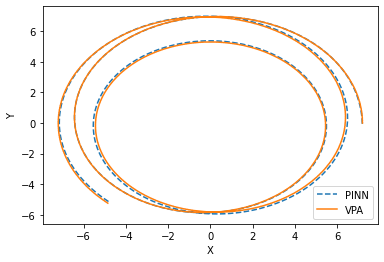

Epoch [20600/24000], Loss: 12.39,   LOSS_function: 7.661,   LOSS_E:6.944e-05,    LOSS_initial: 1.374e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.321e-05,    time: 1022.251528263092
loss_compared with real:0.019395,   miu_train:0.0001927,  E:25.1    lossmean:-0.0003804
Epoch [20700/24000], Loss: 11.43,   LOSS_function: 8.36,   LOSS_E:4.496e-05,    LOSS_initial: 1.234e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.321e-05,    time: 1029.8649163246155
loss_compared with real:0.019204,   miu_train:0.0001906,  E:25.1    lossmean:0.0008508
Epoch [20800/24000], Loss: 13.06,   LOSS_function: 8.169,   LOSS_E:7.136e-05,    LOSS_initial: 1.001e-07,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.321e-05,    time: 1037.494530916214
loss_compared with real:0.01947,   miu_train:0.000191,  E:25.11    lossmean:-0.003028
Epoch [20900/24000], Loss: 16.43,   LOSS_function: 11,   LOSS_E:7.945e-05,    LOSS_initial: 5.455e-08,


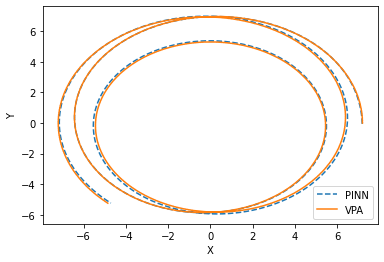

Epoch [21100/24000], Loss: 24.17,   LOSS_function: 6.748,   LOSS_E:0.0002557,    LOSS_initial: 5.355e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.182e-05,    time: 1061.8975384235382
loss_compared with real:0.019518,   miu_train:0.0001882,  E:25.11    lossmean:-0.006766
Epoch [21200/24000], Loss: 16.16,   LOSS_function: 9.019,   LOSS_E:0.0001047,    LOSS_initial: 3.64e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.182e-05,    time: 1069.4670414924622
loss_compared with real:0.01968,   miu_train:0.0001875,  E:25.11    lossmean:-0.007707
Epoch [21300/24000], Loss: 15.38,   LOSS_function: 8.228,   LOSS_E:0.000105,    LOSS_initial: 1.256e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.182e-05,    time: 1077.0402421951294
loss_compared with real:0.019131,   miu_train:0.0001851,  E:25.1    lossmean:-0.00515
Epoch [21400/24000], Loss: 16.64,   LOSS_function: 10,   LOSS_E:9.729e-05,    LOSS_initial: 6.349e-08,

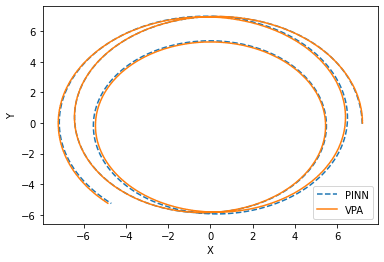

Epoch [21600/24000], Loss: 32.05,   LOSS_function: 8.762,   LOSS_E:0.0003419,    LOSS_initial: 1.448e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.182e-05,    time: 1100.5971658229828
loss_compared with real:0.022294,   miu_train:0.0001887,  E:25.14    lossmean:-0.01945
Epoch [21700/24000], Loss: 16.63,   LOSS_function: 11.83,   LOSS_E:7.037e-05,    LOSS_initial: 4.718e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.182e-05,    time: 1108.0686974525452
loss_compared with real:0.022616,   miu_train:0.0001886,  E:25.15    lossmean:-0.0202
Epoch [21800/24000], Loss: 12.85,   LOSS_function: 8.427,   LOSS_E:6.485e-05,    LOSS_initial: 2.155e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.182e-05,    time: 1116.1027779579163
loss_compared with real:0.021464,   miu_train:0.0001845,  E:25.13    lossmean:-0.01707
Epoch [21900/24000], Loss: 14.88,   LOSS_function: 7.279,   LOSS_E:0.0001114,    LOSS_initial: 4.237e

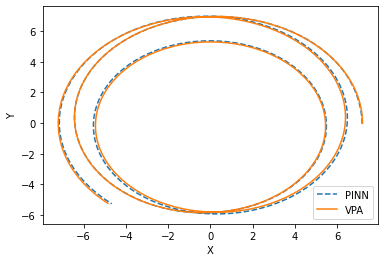

Epoch [22100/24000], Loss: 13.68,   LOSS_function: 8.247,   LOSS_E:7.942e-05,    LOSS_initial: 7.811e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.051e-05,    time: 1139.8466849327087
loss_compared with real:0.023509,   miu_train:0.000185,  E:25.14    lossmean:-0.02475
Epoch [22200/24000], Loss: 13.25,   LOSS_function: 7.648,   LOSS_E:8.18e-05,    LOSS_initial: 1.137e-07,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.051e-05,    time: 1147.3463735580444
loss_compared with real:0.024148,   miu_train:0.0001845,  E:25.15    lossmean:-0.02622
Epoch [22300/24000], Loss: 11.23,   LOSS_function: 8.55,   LOSS_E:3.921e-05,    LOSS_initial: 3.663e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.051e-05,    time: 1154.918930530548
loss_compared with real:0.023108,   miu_train:0.0001812,  E:25.14    lossmean:-0.02356
Epoch [22400/24000], Loss: 13.73,   LOSS_function: 7.601,   LOSS_E:8.943e-05,    LOSS_initial: 1.247e-07

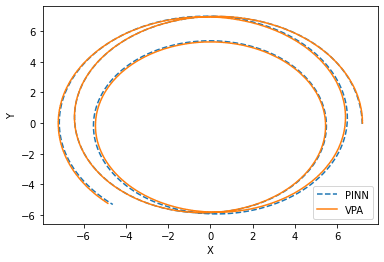

Epoch [22600/24000], Loss: 19.89,   LOSS_function: 6.758,   LOSS_E:0.0001928,    LOSS_initial: 1.353e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.051e-05,    time: 1179.0416946411133
loss_compared with real:0.026664,   miu_train:0.0001826,  E:25.15    lossmean:-0.03287
Epoch [22700/24000], Loss: 13.53,   LOSS_function: 7.837,   LOSS_E:8.313e-05,    LOSS_initial: 1.187e-07,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.051e-05,    time: 1186.6718139648438
loss_compared with real:0.023841,   miu_train:0.0001772,  E:25.12    lossmean:-0.02714
Epoch [22800/24000], Loss: 12.5,   LOSS_function: 7.218,   LOSS_E:7.73e-05,    LOSS_initial: 6.709e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:2.051e-05,    time: 1194.3503229618073
loss_compared with real:0.023573,   miu_train:0.0001747,  E:25.12    lossmean:-0.02744
Epoch [22900/24000], Loss: 14.63,   LOSS_function: 8.345,   LOSS_E:9.216e-05,    LOSS_initial: 2.406e-

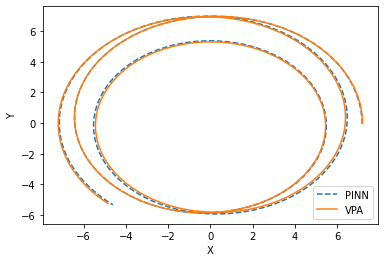

Epoch [23100/24000], Loss: 17.02,   LOSS_function: 9.906,   LOSS_E:0.0001044,    LOSS_initial: 2.885e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:1.928e-05,    time: 1217.9504597187042
loss_compared with real:0.028752,   miu_train:0.0001754,  E:25.15    lossmean:-0.03719
Epoch [23200/24000], Loss: 14.82,   LOSS_function: 7.579,   LOSS_E:0.0001062,    LOSS_initial: 2.108e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:1.928e-05,    time: 1225.535376548767
loss_compared with real:0.033349,   miu_train:0.0001779,  E:25.17    lossmean:-0.04554
Epoch [23300/24000], Loss: 10.92,   LOSS_function: 6.282,   LOSS_E:6.792e-05,    LOSS_initial: 3.574e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:1.928e-05,    time: 1233.3089439868927
loss_compared with real:0.029052,   miu_train:0.0001735,  E:25.14    lossmean:-0.03958
Epoch [23400/24000], Loss: 13.84,   LOSS_function: 5.987,   LOSS_E:0.000115,    LOSS_initial: 7.716e-

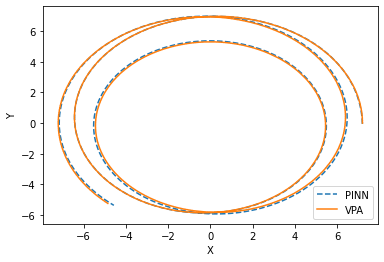

Epoch [23600/24000], Loss: 13.03,   LOSS_function: 8.936,   LOSS_E:6.007e-05,    LOSS_initial: 1.236e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:1.928e-05,    time: 1258.014399766922
loss_compared with real:0.032605,   miu_train:0.0001713,  E:25.15    lossmean:-0.04431
Epoch [23700/24000], Loss: 15.79,   LOSS_function: 7.188,   LOSS_E:0.0001261,    LOSS_initial: 5.015e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:1.928e-05,    time: 1265.8306715488434
loss_compared with real:0.035184,   miu_train:0.0001694,  E:25.15    lossmean:-0.04887
Epoch [23800/24000], Loss: 11.52,   LOSS_function: 7.672,   LOSS_E:5.627e-05,    LOSS_initial: 4.637e-08,
lamda1:1,    lamda2:6.808e+04,    lamda3:3.138e+05,      learn rate:1.928e-05,    time: 1273.6620388031006
loss_compared with real:0.034078,   miu_train:0.0001689,  E:25.14    lossmean:-0.04829
Epoch [23900/24000], Loss: 16.29,   LOSS_function: 6.596,   LOSS_E:0.0001419,    LOSS_initial: 1.007e

In [85]:
import time
start_time = time.time()#计时
epochs = 24000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    l00=(u(torch.tensor([8000*interval]))[0] - target_x0)**2
    l01=(u(torch.tensor([8000*interval]))[1] - target_y0)**2
    l02=(u(torch.tensor([8000*interval]))[2] - target_z0)**2
    
    l20=(u(torch.tensor([4000*interval]))[0] - target_x2)**2
    l21=(u(torch.tensor([4000*interval]))[1] - target_y2)**2
    l22=(u(torch.tensor([4000*interval]))[2] - target_z2)**2
   
   
    l0=l00+l01+l02+l20+l21+l22
    
    if (i+1)%10==0:
       
        target_vx0=gradients(u(t0)[0],t0,1)
        target_vy0=gradients(u(t0)[1],t0,1)
        target_vz0=gradients(u(t0)[2],t0,1)
        with torch.no_grad():
            tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
    if i<4000:
        lpde=LOSS1(u)[0]
        lE=LOSS1(u)[1]
        
        n_al=10000
        n_real=20
    if i>=4000 and i<8000:
        lpde=LOSS2(u)[0]
        lE=LOSS2(u)[1]
        
        n_al=20000
        n_real=40
    if i>=8000 and i<12000:
        lpde=LOSS3(u)[0]
        lE=LOSS3(u)[1]
        
        n_al=30000
        n_real=60
    if i>=12000 and i<16000:
        lpde=LOSS4(u)[0]
        lE=LOSS4(u)[1]
        
        n_al=40000
        n_real=80
    if i>=16000:
        lpde=LOSS5(u)[0]
        lE=LOSS5(u)[1]
        
        n_al=50000
        n_real=100
    if i==20000:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.04
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate

  
    if (i+1)%1000== 0 and (i+1)<15000:
        gradient_lpde=funcweight(lpde)
        gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>1e-5:
        lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
    if (i+1)%1000== 0 and lE>1e-5:
        lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    if i%500==0:
        plot_trajectory_during_loop()
    
    if (i+1)%1000 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.94
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_al+1+jump), interval*int(n_al/n_real))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        E=vx_test**2+vy_test**2+vz_test**2
        loss_test = loss(x_test,x_real[:(n_real+1)])+loss(y_test,y_real[:(n_real+1)])+loss(z_test,z_real[:(n_real+1)])
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        lossmean_test = torch.sum(x_test-x_real[:(n_real+1)]+y_test-y_real[:(n_real+1)]+z_test-z_real[:(n_real+1)])/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},  E:{E.mean():.4g}    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
        E_list.append(E.mean().item())
        lamda1_list.append(lamda1)
        lamda2_list.append(lamda2)
        lamda3_list.append(lamda3)
        l_withoutweight_list.append(l_withoutweight.item())
        time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
        miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


In [86]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [87]:
file_lists = [loss_list, lpde_list, l0_list, lE_list,E_list,lamda1_list, lamda2_list,lamda3_list,l_withoutweight_list, time_list, loss_test_list, lossmean_test_list,miu_train_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt','hh_E.txt', 'hh_lamda1.txt','hh_lamda2.txt', 'hh_lamda3.txt', 'hh_l_withoutweight.txt', 'hh_time.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt','hh_miu_train_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


In [88]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump),20):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

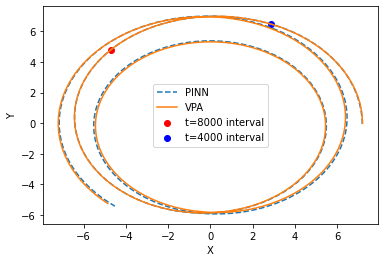

In [89]:


# 绘制轨迹，2维
plt.plot(x_coordinates, y_coordinates, linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt, label='VPA')

# 标识 target_x0 和 target_x2 的点
plt.scatter(target_x0.numpy(), target_y0.numpy(), color='red', marker='o', label='t=8000 interval')
plt.scatter(target_x2.numpy(), target_y2.numpy(), color='blue', marker='o', label='t=4000 interval')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN neural network VS classic calculation')
plt.show()


In [90]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# # 假设 x_real_plt 和 y_real_plt 是给定的 PyTorch 张量

# # 将 PyTorch 张量转换为 NumPy 数组
# x_np = x_coordinates.flatten()
# y_np = y_coordinates.flatten()

# # 计算 FFT
# fft_result = np.fft.fft(y_np)

# # 计算频谱密度
# fft_freq = np.fft.fftfreq(len(y_np), d=(x_np[1]-x_np[0]))
# power_spectrum_density = np.abs(fft_result)**2

# # 计算功率占比
# total_power = np.sum(power_spectrum_density)
# power_percentage = power_spectrum_density / total_power

# # 按频率从小到大的顺序对数据进行排序
# sorted_indices = np.argsort(fft_freq)
# sorted_freq = fft_freq[sorted_indices]
# sorted_power_percentage = power_percentage[sorted_indices]

# # 绘制功率占比的对数图
# plt.figure(figsize=(10, 6))
# plt.semilogy(sorted_freq, sorted_power_percentage, color='blue')
# plt.title('PINN Power Spectrum Density (Log Scale)')
# plt.xlabel('Frequency')
# plt.ylabel('Log Power')
# plt.grid(True)
# plt.xlim(-20, 20)
# plt.show()

# # 计算加权平均值
# weighted_average = np.sum(np.abs(sorted_freq) * sorted_power_percentage) / np.sum(sorted_power_percentage)

# print("PINN频谱密度频率平均值为:", weighted_average)


In [91]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# # 假设 x_real_plt 和 y_real_plt 是给定的 PyTorch 张量

# # 将 PyTorch 张量转换为 NumPy 数组
# x_np = x_real_plt.numpy().flatten()
# y_np = y_real_plt.numpy().flatten()

# # 计算 FFT
# fft_result = np.fft.fft(y_np)

# # 计算频谱密度
# fft_freq = np.fft.fftfreq(len(y_np), d=(x_np[1]-x_np[0]))
# power_spectrum_density = np.abs(fft_result)**2

# # 计算功率占比
# total_power = np.sum(power_spectrum_density)
# power_percentage = power_spectrum_density / total_power

# # 按频率从小到大的顺序对数据进行排序
# sorted_indices = np.argsort(fft_freq)
# sorted_freq = fft_freq[sorted_indices]
# sorted_power_percentage = power_percentage[sorted_indices]

# # 绘制功率占比的对数图
# plt.figure(figsize=(10, 6))
# plt.semilogy(sorted_freq, sorted_power_percentage, color='blue')
# plt.title('Classic Power Spectrum Density (Log Scale)')
# plt.xlabel('Frequency')
# plt.ylabel('Log Power')
# plt.grid(True)
# plt.xlim(-20, 20)
# plt.show()

# # 计算加权平均值
# weighted_average = np.sum(np.abs(sorted_freq) * sorted_power_percentage) / np.sum(sorted_power_percentage)

# print("classic频谱密度频率平均值为:", weighted_average)

In [92]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


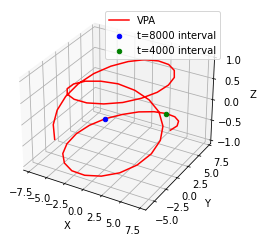

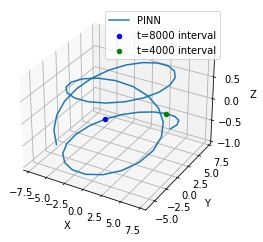

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 绘制 classic computation 的轨迹
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/1000)], y_plt[::int(n_all/1000)], z_plt[::int(n_all/1000)], color='red', label='VPA')

# 标识 target_x0 和 target_x2 的点
ax.scatter(target_x0.numpy(), target_y0.numpy(), target_z0.numpy(), color='blue', label='t=8000 interval')
ax.scatter(target_x2.numpy(), target_y2.numpy(), target_z2.numpy(), color='green', label='t=4000 interval')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# 绘制 neural network 的轨迹
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_coordinates[::int(n_all/1000)], y_coordinates[::int(n_all/1000)], z_coordinates[::int(n_all/1000)], label='PINN')

# 标识 target_x0 和 target_x2 的点
ax.scatter(target_x0.numpy(), target_y0.numpy(), target_z0.numpy(), color='blue', label='t=8000 interval')
ax.scatter(target_x2.numpy(), target_y2.numpy(), target_z2.numpy(), color='green', label='t=4000 interval')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field (Neural Network)')
plt.show()


In [94]:
# #计算轨迹偏差
# x_n=torch.tensor(x_coordinates).view(-1,1)
# y_n=torch.tensor(y_coordinates).view(-1,1)
# z_n=torch.tensor(z_coordinates).view(-1,1)

# x_c = torch.tensor(x_real_plt)
# y_c = torch.tensor(y_real_plt)
# z_c = torch.tensor(z_real_plt)
# diff=loss(x_n,x_c)+loss(y_n,y_c)+loss(z_n,z_c)#差不多是平均误差距离的平方d^2=dx^2+dy^2+dz^2
# diff

In [95]:
#用作提醒
# loss_list=[]#总损失，带权重
# lpde_list=[]#方程项损失
# lcq_list=[]#守恒量损失，无权重
# l0_list=[]#初态损失
# lE_list=[]#能量项损失loss，也是与真实能量做对比diff
# lmiu_list=[]#磁矩损失loss，有特定损失函数
# lamda1_list=[]#方程项权重
# lamda2_list=[]#能量项权重
# lamda3_list=[]#初态权重
# lamda4_list=[]#磁矩损失权重
# l_withoutweight_list=[]#总损失，不带权重
# time_list=[]#训练时间记录
# loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
# lmiu_test_list=[]#部分时刻点，输出磁矩与真实磁矩的误差的平方
# lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心

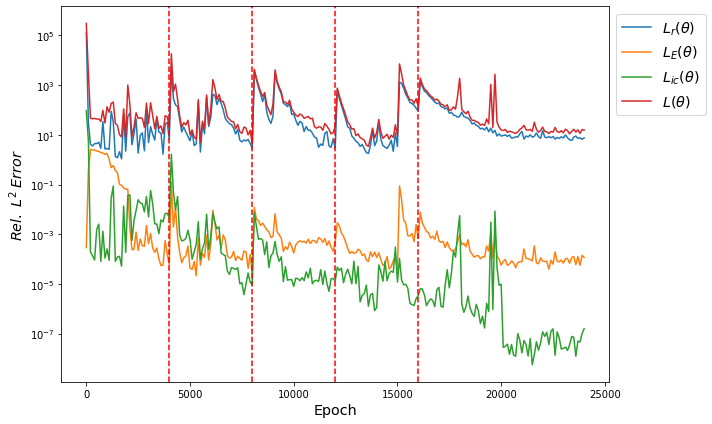

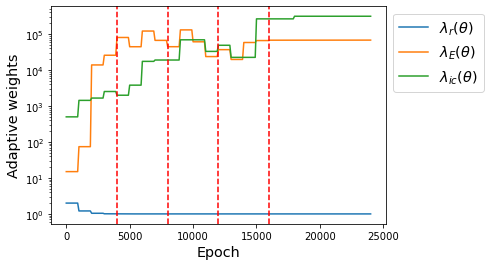

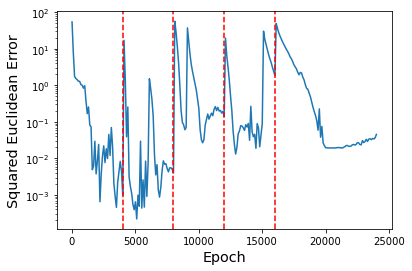

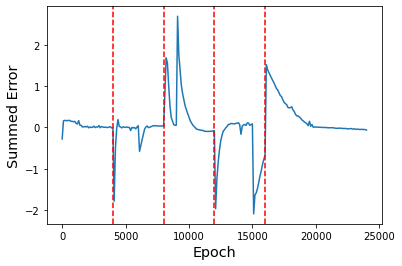

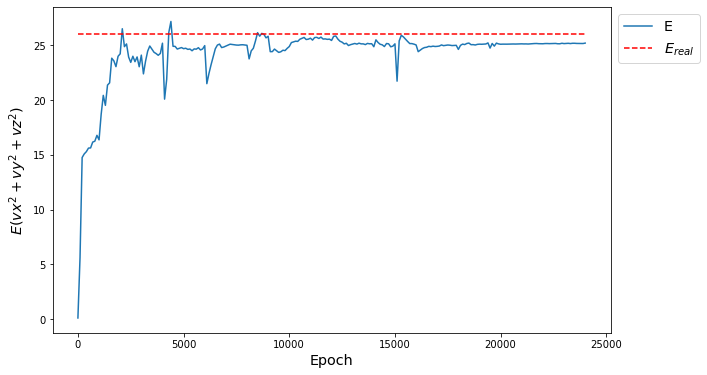

In [101]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))


# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000, 8000, 12000, 16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
#plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Adaptive weights', fontsize='x-large')
# plt.title('Adaptive weights during training process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000, 8000, 12000, 16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')


# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000, 8000, 12000, 16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.show()  # 绘图


plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')

# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000, 8000, 12000, 16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.show()#绘图

# 绘制曲线
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array, E_list, label='E')
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$E(vx^2+vy^2+vz^2)$', fontsize='x-large')
# plt.title('Kinetic energy (sum of squared velocities) during training process')
# 绘制直虚线
plt.hlines(y=26, xmin=epoch_array[0], xmax=epoch_array[-1], colors='r', linestyles='dashed', label=r'$E_{real}$')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()  # 绘图


In [97]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),20):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[int(i/20-jump)]
    y_real_tl = y_real_plt[int(i/20-jump)]
    z_real_tl = z_real_plt[int(i/20-jump)]
#     vx_real_tl = vx_real_plt[i-jump]
#     vy_real_tl = vy_real_plt[i-jump]
#     vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 20*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [98]:
# 用作提醒
# lpde_tl_list=[]
# lcq_tl_list=[]
# lE_tl_list=[]
# lmiu_tl_list=[]
# loss_test_tl_list=[]
# lmiu_test_tl_list=[]
# lossmean_test_tl_list=[]

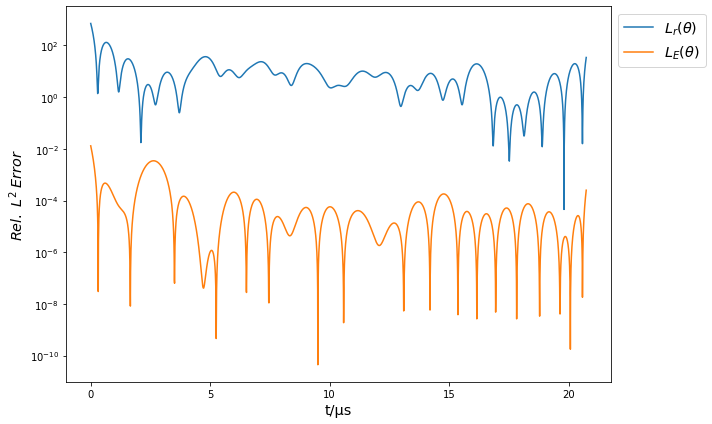

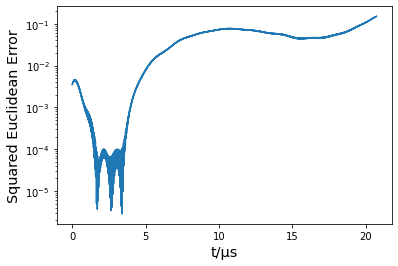

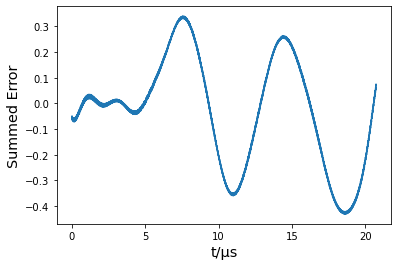

In [99]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()

plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图

plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [100]:
# #部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,的标准差。我希望这个数和小圆轨迹半径有关
# import statistics
# standard_deviation=(statistics.variance(lossmean_test_tl_list))**0.5
# print('standard_deviation',standard_deviation)

In [57]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
